# Gradient-based semantle solving agent

Defines an agent that uses a discrete version of gradient descent in embedding space to find the semantle target/secret word

In [1]:
from english_words import english_words_set
import matplotlib.pyplot as plt
import numpy as np

from semantle_simulator import SemantleSimulator
from similarity_model import SimilarityModel
import gradient_solver as gs

## Simulator for semantle

In [2]:
sem_sim = SemantleSimulator()

In [3]:
sem_sim.target = 'habitat'

## Agent capabilities

Agent reuses semantle embedding space, but could potentially use a different semantic representation. Word list is closer (~30k) to what a human could potentially recall.

In [4]:
agent_semantics = sem_sim.wv
base_vocabulary = english_words_set #set(np.random.choice(list(english_words_set), 100))
if sem_sim.target not in base_vocabulary:
    base_vocabulary.add(sem_sim.target)
    
similarity = SimilarityModel(agent_semantics, base_vocabulary)

## Run the solving agent

The agent builds a gradient network to direct its guesses towards the target

In [5]:
solver = gs.GradientSolver(similarity, seeds=3, log=True)

In [6]:
%%time
target, steps = solver.solve(sem_sim)
print(f'semantle target "{sem_sim.target}"')
print(f'solver reached "{similarity.word_string(target)}" (id {target}) in {steps} steps')

semantle target "habitat"
solver reached "habitat" (id 11626) in 52 steps
CPU times: user 2.13 s, sys: 516 ms, total: 2.65 s
Wall time: 1.39 s


## Visualise the results

In [7]:
guess_history = solver.logging['guess']
basis_history = solver.logging['basis']

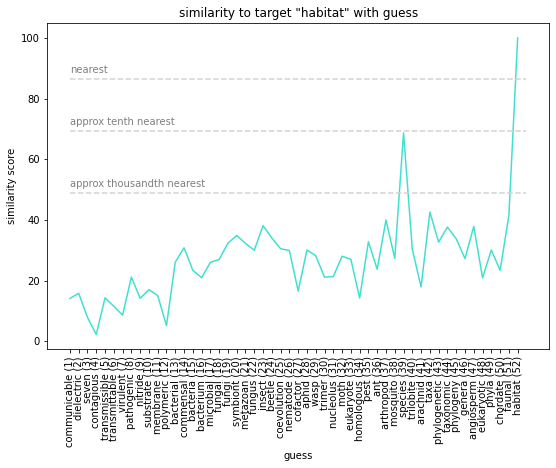

In [8]:
similarity_history = np.array([sem_sim.score_guess(similarity.word_string(g)) for g in guess_history])
tgt_cal = sem_sim.score_calibration()
plt.figure(figsize=(9, 6))
plt.plot(similarity_history, c='turquoise')
plt.plot([0, len(similarity_history)], [tgt_cal[0][1], tgt_cal[0][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[0][1] + 2, 'nearest', c='grey') 
plt.plot([0, len(similarity_history)], [tgt_cal[1][1], tgt_cal[1][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[1][1] + 2, 'approx tenth nearest', c='grey') 
plt.plot([0, len(similarity_history)], [tgt_cal[2][1], tgt_cal[2][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[2][1] + 2, 'approx thousandth nearest', c='grey') 
plt.title(f'similarity to target "{sem_sim.target}" with guess')
plt.ylabel('similarity score')
plt.xlabel('guess')
xtick_lim = 46
xtick_step = max(1, int(round(len(similarity_history) / xtick_lim)))
xticks = range(0, len(similarity_history), xtick_step)
xtick_labels = [f'{similarity.vocabulary[guess_history[xt]]} ({xt + 1})' for xt in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
plt.show()

### Visualise search strategy

The visualisation of the gradient descent search strategy is based on run length encoding using code published at https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi by user Thomas Browne.

In [9]:
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

In [10]:
top_node_history = np.array([b[0] for b in basis_history])
rls_top_node = rle(top_node_history)
idrl_top_node = np.repeat(np.arange(rls_top_node[0].size), rls_top_node[0])
spoke_node_history = np.array([b[1][2] for b in basis_history])
rls_spoke_node = rle(spoke_node_history)
idrl_spoke_node = np.repeat(np.arange(rls_spoke_node[0].size), rls_spoke_node[0])

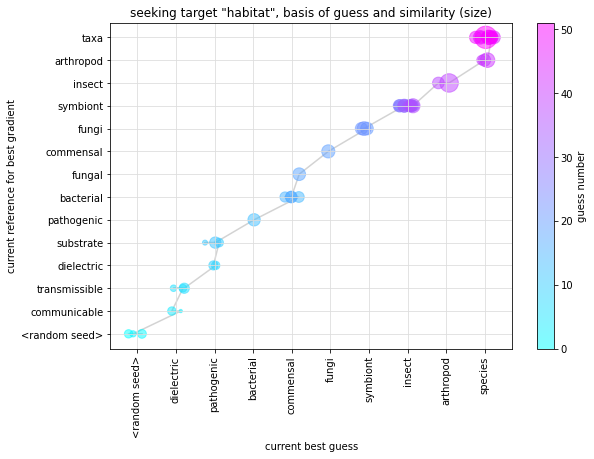

In [11]:
word_array = np.array(similarity.vocabulary)
s_sim_hist = np.maximum(similarity_history, 0.1)
h_noise = np.random.rand(len(top_node_history)) * 0.5 - 0.25
h_labels = word_array[rls_top_node[2]]
h_labels[0] = '<random seed>'
v_labels = word_array[rls_spoke_node[2]]
v_labels[0] = '<random seed>'

plt.figure(figsize=(9, 6))
plt.scatter(idrl_top_node + h_noise, idrl_spoke_node, s=(s_sim_hist * 5),
            c=range(len(top_node_history)), cmap='cool', alpha=0.5, zorder=1)
plt.plot(idrl_top_node + h_noise, idrl_spoke_node, c='lightgrey', zorder=0)
plt.xticks(np.arange(rls_top_node[0].size), labels=h_labels, rotation=90)
plt.xlabel('current best guess')
plt.yticks(np.arange(rls_spoke_node[0].size), labels=v_labels)
plt.ylabel('current reference for best gradient')
plt.colorbar(label='guess number')
plt.grid('on', color='#ddd')
plt.title(f'seeking target "{sem_sim.target}", basis of guess and similarity (size)')
plt.show()

### Visualise results and search together

In [12]:
basis_pairs_top = np.repeat(h_labels, rls_top_node[0])
basis_pairs_spoke = np.repeat(v_labels, rls_spoke_node[0])
basis_pairs_label = np.char.add(np.char.add(basis_pairs_spoke, ' > '), basis_pairs_top)
rls_basis_pairs = rle(basis_pairs_label)

idrl_basis_pair = np.repeat(np.arange(rls_basis_pairs[0].size), rls_basis_pairs[0])
idrl_offsets = np.concatenate([np.arange(rls_basis_pairs[0][i]) for i in range(rls_basis_pairs[0].size)])
basis_x_pos = idrl_basis_pair + idrl_offsets / np.max(idrl_offsets) / 2
cumul_similarity_max = np.maximum.accumulate(similarity_history)
rls_new_sim_max = rle(cumul_similarity_max)
reference_labels = np.char.add('+ ', word_array[spoke_node_history[rls_basis_pairs[1]]])
reference_labels[0] = ''

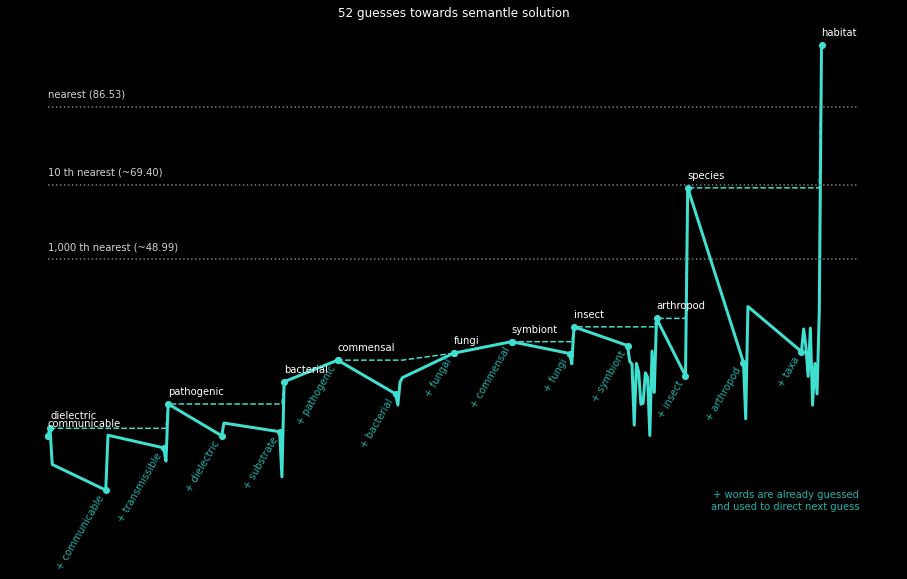

In [13]:
plt.figure(figsize=(16, 9), facecolor='black')
plt.plot(basis_x_pos, similarity_history, c='turquoise', lw=3)
plt.plot(basis_x_pos, cumul_similarity_max, '--', c='turquoise')
plt.scatter(basis_x_pos[rls_new_sim_max[1]], cumul_similarity_max[rls_new_sim_max[1]], c='turquoise')
for m in rls_new_sim_max[1]:
    plt.text(basis_x_pos[m], cumul_similarity_max[m] + 2, word_array[guess_history[m]], c='white')
for i in range(rls_basis_pairs[0].size):
    plt.text(i, similarity_history[rls_basis_pairs[1][i]] - 1, reference_labels[i] + ' ',
             rotation=60, ha='right', rotation_mode='anchor', c='lightseagreen')
plt.scatter(range(rls_basis_pairs[0].size), similarity_history[rls_basis_pairs[1]], c='turquoise')

plt.plot([0, rls_basis_pairs[0].size], [tgt_cal[0][1], tgt_cal[0][1]], ':', c='grey')
plt.text(0, tgt_cal[0][1] + 2, f'nearest ({tgt_cal[0][1]:.2f})', c='lightgrey') 
plt.plot([0, rls_basis_pairs[0].size], [tgt_cal[1][1], tgt_cal[1][1]], ':', c='grey')
plt.text(0, tgt_cal[1][1] + 2, f'10 th nearest (~{tgt_cal[1][1]:.2f})', c='lightgrey') 
plt.plot([0, rls_basis_pairs[0].size], [tgt_cal[2][1] + 4, tgt_cal[2][1] + 4], ':', c='grey')
plt.text(0, tgt_cal[2][1] + 6, f'1,000 th nearest (~{tgt_cal[2][1]:.2f})', c='lightgrey') 

plt.axis('off')
plt.title(f'{len(guess_history)} guesses towards semantle solution', c='white')
plt.text(rls_basis_pairs[0].size, -2, '+ words are already guessed\nand used to direct next guess', ha='right', c='lightseagreen')

plt.show()